In [113]:
import numpy as np
import re
import os
import autokeras as ak
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, LayerNormalization
from ReadData import read_data_as_img, read_data_structured, read_data_st
from Preprocessing import ros, smote, adasyn
from Results import report_results_imagedata, make_spider_by_temp, report_results_st, test_results
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras import Sequential
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, log_loss, fowlkes_mallows_score, cohen_kappa_score, precision_score, recall_score
from datetime import datetime
from contextlib import redirect_stdout
seed = 42
np.random.seed(seed)

In [4]:
data_dir = "../data"
X_train, y_train = read_data_st(data_dir, "train")
X_val, y_val = read_data_st(data_dir, "val")
X_test, y_test = read_data_st(data_dir, "test")

#X_train = np.concatenate((X_train, X_val))
#y_train = np.concatenate((y_train, y_val))
#X_train, y_train = smote(X_train, y_train)
X_train = X_train.reshape(*X_train.shape[:3], 1)
X_test = X_test.reshape(*X_test.shape[:3], 1)

In [56]:
def widenet():
    model = keras.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(11,200,1)))
    model.add(MaxPooling2D((1, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=256, activation='relu'))

    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "AUC"])
    return model

In [114]:
model = widenet()

model.summary()

history = model.fit(X_train, y_train,
            shuffle=True,
            batch_size=32,
            epochs=3,
            verbose=False,
            validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 9, 198, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 99, 32)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 9, 99, 32)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 97, 32)         9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 48, 32)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 3, 48, 32)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 46, 32)        

PermissionError: [Errno 13] Permission denied: '/trainHistoryDict'

In [115]:
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [62]:
history.history.

{'loss': [0.2939531207084656, 0.2760050594806671, 0.2724096179008484],
 'accuracy': [0.8863096237182617, 0.886015772819519, 0.8862828612327576],
 'auc': [0.8074551820755005, 0.8355605602264404, 0.8380454778671265],
 'val_loss': [0.15568280220031738, 0.12831518054008484, 0.12047021090984344],
 'val_accuracy': [1.0, 1.0, 1.0],
 'val_auc': [0.0, 0.0, 0.0]}

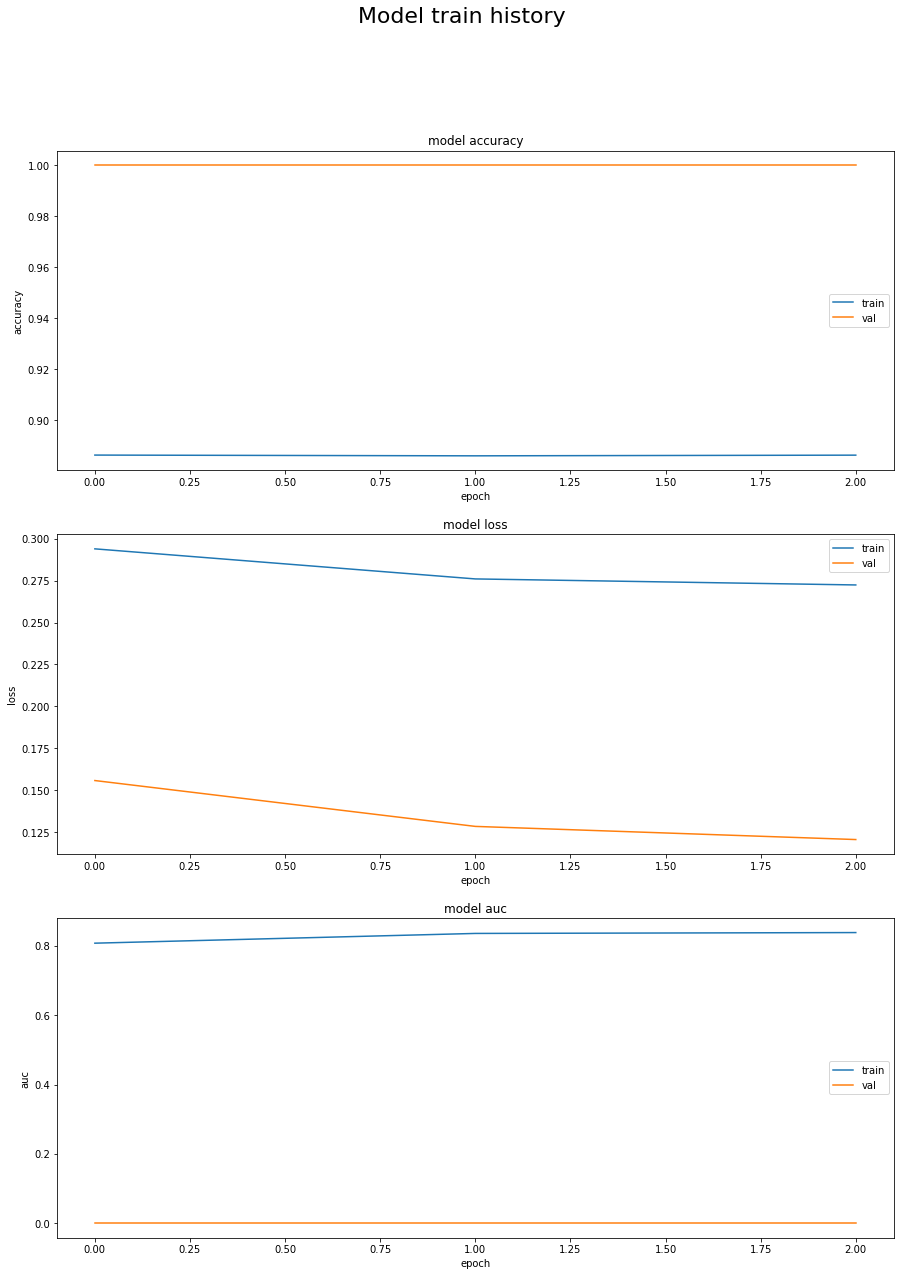

In [112]:
plot_train_history(history, "hola.png")

In [58]:
print("Train metrics:")
test_results(X_train, y_train, model)
print("Test metrics:")
test_results(X_test, y_test, model)

Train metrics:
	Accuracy score:  0.9146044254302979

	Binary crossentropy : 0.22706757485866547

	AUC ROC: 0.8635118007659912
Test metrics:
	Accuracy score:  0.9070324897766113

	Binary crossentropy : 0.23398719727993011

	AUC ROC: 0.8641296625137329


In [54]:
def test_results(X_test, y_test, model):
    test_bc, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=False)

    print(f"\tAccuracy score:  {test_acc}")
    print()
    print(f"\tBinary crossentropy : {test_bc}")
    print()
    print(f"\tAUC ROC: {test_auc}")